In [4]:
from google.colab import files

# Opens a file upload dialog
uploaded = files.upload()



Saving train_FD001_processed.csv to train_FD001_processed.csv


In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import random

# Random seed setup for reproducibility
SEED = 40
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration
DATA_PATH = 'train_FD001_processed.csv'
MODEL_PATH = 'best_rul_gru_model.h5'
SEQ_LENGTH = 50              # window size
MAX_RUL = 100                # RUL clipping value


In [6]:
df = pd.read_csv(DATA_PATH)
print(f"Data loaded successfully. Shape: {df.shape}")
#Feature Engineering
print(f"\nApplying RUL Clipping at {MAX_RUL} cycles...")
df['RUL_Clipped'] = df['RUL'].clip(upper=MAX_RUL)

#Define the features to be used in the GRU
FEATURE_COLUMNS = [col for col in df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL', 'RUL_Clipped']]
TARGET_COLUMN = 'RUL_Clipped'

#Function to generate sequences for each engine unit
def generate_sequences(df, window_size, feature_cols, target_col):
    X, y, groups = [], [], []
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit]
        features = unit_data[feature_cols].values
        target = unit_data[target_col].values
        unit_groups = unit_data['unit_number'].values

        for i in range(len(unit_data) - window_size + 1):
            X.append(features[i : i + window_size])
            y.append(target[i + window_size - 1])
            groups.append(unit_groups[i + window_size - 1])

    return np.array(X), np.array(y), np.array(groups)

X, y, groups = generate_sequences(df, SEQ_LENGTH, FEATURE_COLUMNS, TARGET_COLUMN)
print(f"Sequences generated successfully with WINDOW_SIZE={SEQ_LENGTH}.")
print(f"X shape: {X.shape}, y shape: {y.shape}, Groups shape: {groups.shape}")

Data loaded successfully. Shape: (20631, 23)

Applying RUL Clipping at 100 cycles...
Sequences generated successfully with WINDOW_SIZE=50.
X shape: (15731, 50, 20), y shape: (15731,), Groups shape: (15731,)


In [7]:
# Unit-Based Data Splitting (Train, Validation, Test)
from sklearn.model_selection import GroupShuffleSplit

# Primary Train-Test Split
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))

X_train_full, X_test = X[train_idx], X[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

# Secondary Train-Validation Split (from training set)
val_splitter = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, val_idx = next(val_splitter.split(X_train_full, y_train_full, groups=groups_train))

X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

# Summary
print(f"\n✅ Data Split Summary:")
print(f"Training samples   : {X_train.shape[0]}")
print(f"Validation samples : {X_val.shape[0]}")
print(f"Testing samples    : {X_test.shape[0]}")



✅ Data Split Summary:
Training samples   : 10648
Validation samples : 1927
Testing samples    : 3156


In [8]:
# Build the Optimized Bi-LSTM Model
from tensorflow.keras.layers import LSTM, Bidirectional

def build_bilstm_model(timesteps, features):
    optimizer = Adam(learning_rate=0.0005)

    model = Sequential([
        # First BiLSTM layer
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
        Dropout(0.3),

        # Second BiLSTM layer
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),

        # Dense layers for feature consolidation
        Dense(32, activation='relu'),
        Dense(10, activation='relu'),

        # Output layer for RUL prediction
        Dense(1)
    ])

    # Compile with RMSE metric
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])

    return model

# Build and summarize model
model = build_bilstm_model(X_train.shape[1], X_train.shape[2])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,397 (1.23 MB)

 Trainable params: 321,397 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Train the Model

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 4273.3052 - mae: 56.9252 - rmse: 64.9641
Epoch 1: val_loss improved from inf to 1155.72449, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 323ms/step - loss: 4265.1021 - mae: 56.8595 - rmse: 64.8977 - val_loss: 1155.7245 - val_mae: 30.7793 - val_rmse: 33.9959
Epoch 2/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 1129.4927 - mae: 29.9302 - rmse: 33.6071
Epoch 2: val_loss improved from 1155.72449 to 1123.88208, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - loss: 1129.5594 - mae: 29.9305 - rmse: 33.6081 - val_loss: 1123.8821 - val_mae: 30.0158 - val_rmse: 33.5243
Epoch 3/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 1119.2725 - mae: 29.6679 - rmse: 33.4528
Epoch 3: val_loss did not improve from 1123.88208
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - loss: 1119.3876 - mae: 29.6693 - rmse: 33.4545 - val_loss: 1125.3380 - val_mae: 30.0758 - val_rmse: 33.5461
Epoch 4/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1122.7209 - mae: 29.7436 - rmse: 33.5043
Epoch 4: val_loss improved from 1123.88208 to 1119.79968, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - loss: 1122.8027 - mae: 29.7446 - rmse: 33.5055 - val_loss: 1119.7997 - val_mae: 29.9995 - val_rmse: 33.4634
Epoch 5/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1041.5947 - mae: 28.5980 - rmse: 32.2514
Epoch 5: val_loss improved from 1119.79968 to 286.66479, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - loss: 1040.5051 - mae: 28.5797 - rmse: 32.2338 - val_loss: 286.6648 - val_mae: 14.2936 - val_rmse: 16.9312
Epoch 6/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 309.9175 - mae: 14.2101 - rmse: 17.6021
Epoch 6: val_loss improved from 286.66479 to 272.94693, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - loss: 309.8416 - mae: 14.2077 - rmse: 17.5999 - val_loss: 272.9469 - val_mae: 13.8482 - val_rmse: 16.5211
Epoch 7/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 249.9958 - mae: 12.2764 - rmse: 15.8097
Epoch 7: val_loss improved from 272.94693 to 231.68614, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - loss: 249.9512 - mae: 12.2749 - rmse: 15.8083 - val_loss: 231.6861 - val_mae: 12.1294 - val_rmse: 15.2212
Epoch 8/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 235.0748 - mae: 11.8090 - rmse: 15.3080
Epoch 8: val_loss did not improve from 231.68614
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 318ms/step - loss: 235.1707 - mae: 11.8114 - rmse: 15.3113 - val_loss: 249.6106 - val_mae: 12.6289 - val_rmse: 15.7991
Epoch 9/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 241.7538 - mae: 11.8407 - rmse: 15.5462
Epoch 9: val_loss did not improve from 231.68614
167/167 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - loss: 241.7717 - mae: 11.8409 - rmse: 15.5468 - val_loss: 263.7177 - val_mae: 12.9067 - val_rmse: 16.2394
Epoch 10/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 227.2555 - mae: 11.3718 - rmse: 15.0734
Epoch 10: val_loss improved from 231.68614 to 215.77788, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - loss: 227.2592 - mae: 11.3718 - rmse: 15.0735 - val_loss: 215.7779 - val_mae: 11.5197 - val_rmse: 14.6894
Epoch 11/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 209.9264 - mae: 10.9793 - rmse: 14.4851
Epoch 11: val_loss improved from 215.77788 to 207.82036, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - loss: 209.9491 - mae: 10.9802 - rmse: 14.4859 - val_loss: 207.8204 - val_mae: 11.4523 - val_rmse: 14.4160
Epoch 12/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 172.4121 - mae: 10.0288 - rmse: 13.1276
Epoch 12: val_loss did not improve from 207.82036
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 317ms/step - loss: 172.4427 - mae: 10.0295 - rmse: 13.1287 - val_loss: 252.0451 - val_mae: 11.7519 - val_rmse: 15.8759
Epoch 13/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 171.8284 - mae: 10.0101 - rmse: 13.0878
Epoch 13: val_loss improved from 207.82036 to 114.74442, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 318ms/step - loss: 171.7094 - mae: 10.0063 - rmse: 13.0832 - val_loss: 114.7444 - val_mae: 8.1171 - val_rmse: 10.7119
Epoch 14/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 127.1659 - mae: 8.5525 - rmse: 11.2755
Epoch 14: val_loss improved from 114.74442 to 106.32327, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 317ms/step - loss: 127.1513 - mae: 8.5520 - rmse: 11.2748 - val_loss: 106.3233 - val_mae: 8.3851 - val_rmse: 10.3113
Epoch 15/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 114.7822 - mae: 8.2237 - rmse: 10.7129
Epoch 15: val_loss improved from 106.32327 to 86.76010, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 330ms/step - loss: 114.7833 - mae: 8.2234 - rmse: 10.7130 - val_loss: 86.7601 - val_mae: 7.2328 - val_rmse: 9.3145
Epoch 16/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 110.4125 - mae: 7.8698 - rmse: 10.5068
Epoch 16: val_loss did not improve from 86.76010
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 110.4039 - mae: 7.8697 - rmse: 10.5064 - val_loss: 99.6559 - val_mae: 7.5896 - val_rmse: 9.9828
Epoch 17/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 103.9651 - mae: 7.7076 - rmse: 10.1953
Epoch 17: val_loss did not improve from 86.76010
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - loss: 103.9634 - mae: 7.7072 - rmse: 10.1952 - val_loss: 104.1572 - val_mae: 7.7449 - val_rmse: 10.2057
Epoch 18/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 104.5024 - mae: 7.7324 - rmse: 10.2216
Epoch 18: val_loss did not improve from 86.76010
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 315ms/step - loss: 104.5121 - mae: 7.7325 - rmse: 10.2221 - val_l

167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 105.4356 - mae: 7.7198 - rmse: 10.2676 - val_loss: 83.5941 - val_mae: 6.8241 - val_rmse: 9.1430
Epoch 20/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 99.4184 - mae: 7.5205 - rmse: 9.9703
Epoch 20: val_loss improved from 83.59415 to 80.92732, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 99.4168 - mae: 7.5204 - rmse: 9.9702 - val_loss: 80.9273 - val_mae: 6.9457 - val_rmse: 8.9960
Epoch 21/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 108.3117 - mae: 7.7563 - rmse: 10.4025
Epoch 21: val_loss did not improve from 80.92732
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 318ms/step - loss: 108.2844 - mae: 7.7555 - rmse: 10.4012 - val_loss: 95.6837 - val_mae: 7.4067 - val_rmse: 9.7818
Epoch 22/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 113.6406 - mae: 7.9845 - rmse: 10.6576
Epoch 22: val_loss did not improve from 80.92732
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - loss: 113.6143 - mae: 7.9837 - rmse: 10.6564 - val_loss: 89.2495 - val_mae: 7.2068 - val_rmse: 9.4472
Epoch 23/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 99.6709 - mae: 7.5361 - rmse: 9.9829
Epoch 23: val_loss improved from 80.92732 to 80.32047, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 54s 325ms/step - loss: 99.6548 - mae: 7.5355 - rmse: 9.9820 - val_loss: 80.3205 - val_mae: 6.5817 - val_rmse: 8.9622
Epoch 24/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 96.0491 - mae: 7.3744 - rmse: 9.7999
Epoch 24: val_loss did not improve from 80.32047
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - loss: 96.0513 - mae: 7.3745 - rmse: 9.8000 - val_loss: 91.8059 - val_mae: 7.0322 - val_rmse: 9.5815
Epoch 25/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 95.7695 - mae: 7.3649 - rmse: 9.7854
Epoch 25: val_loss improved from 80.32047 to 75.09089, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 95.7575 - mae: 7.3645 - rmse: 9.7848 - val_loss: 75.0909 - val_mae: 6.3859 - val_rmse: 8.6655
Epoch 26/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 100.1919 - mae: 7.5880 - rmse: 10.0060
Epoch 26: val_loss did not improve from 75.09089
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 100.2042 - mae: 7.5884 - rmse: 10.0066 - val_loss: 94.6355 - val_mae: 6.8667 - val_rmse: 9.7281
Epoch 27/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 91.4216 - mae: 7.2446 - rmse: 9.5589
Epoch 27: val_loss did not improve from 75.09089
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - loss: 91.4030 - mae: 7.2438 - rmse: 9.5579 - val_loss: 81.2852 - val_mae: 6.5267 - val_rmse: 9.0158
Epoch 28/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 85.7886 - mae: 6.9954 - rmse: 9.2607
Epoch 28: val_loss did not improve from 75.09089
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - loss: 85.8002 - mae: 6.9958 - rmse: 9.2613 - val_loss: 76.9872

167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - loss: 77.8408 - mae: 6.5719 - rmse: 8.8223 - val_loss: 73.0072 - val_mae: 5.7444 - val_rmse: 8.5444
Epoch 39/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 78.0169 - mae: 6.5548 - rmse: 8.8321
Epoch 39: val_loss did not improve from 73.00722
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 335ms/step - loss: 78.0156 - mae: 6.5548 - rmse: 8.8320 - val_loss: 79.3735 - val_mae: 6.0757 - val_rmse: 8.9092
Epoch 40/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 80.1063 - mae: 6.6595 - rmse: 8.9489
Epoch 40: val_loss improved from 73.00722 to 72.95981, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 313ms/step - loss: 80.0993 - mae: 6.6592 - rmse: 8.9485 - val_loss: 72.9598 - val_mae: 5.9211 - val_rmse: 8.5417
Epoch 41/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 75.9541 - mae: 6.4825 - rmse: 8.7145
Epoch 41: val_loss did not improve from 72.95981
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - loss: 75.9612 - mae: 6.4828 - rmse: 8.7150 - val_loss: 77.0817 - val_mae: 6.0508 - val_rmse: 8.7796
Epoch 42/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 76.1508 - mae: 6.4853 - rmse: 8.7261
Epoch 42: val_loss improved from 72.95981 to 72.41792, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 84s 326ms/step - loss: 76.1562 - mae: 6.4856 - rmse: 8.7264 - val_loss: 72.4179 - val_mae: 5.6796 - val_rmse: 8.5099
Epoch 43/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 77.4906 - mae: 6.5488 - rmse: 8.8024
Epoch 43: val_loss did not improve from 72.41792
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - loss: 77.4891 - mae: 6.5488 - rmse: 8.8024 - val_loss: 80.7762 - val_mae: 5.9729 - val_rmse: 8.9876
Epoch 44/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 76.0001 - mae: 6.4698 - rmse: 8.7169
Epoch 44: val_loss did not improve from 72.41792
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - loss: 75.9968 - mae: 6.4695 - rmse: 8.7167 - val_loss: 72.6268 - val_mae: 5.6638 - val_rmse: 8.5221
Epoch 45/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 76.3247 - mae: 6.4846 - rmse: 8.7347
Epoch 45: val_loss improved from 72.41792 to 69.86795, saving model to best_rul_gru_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 314ms/step - loss: 76.3335 - mae: 6.4851 - rmse: 8.7352 - val_loss: 69.8680 - val_mae: 5.7762 - val_rmse: 8.3587
Epoch 46/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 75.5955 - mae: 6.4004 - rmse: 8.6940
Epoch 46: val_loss did not improve from 69.86795
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - loss: 75.5927 - mae: 6.4005 - rmse: 8.6938 - val_loss: 74.8411 - val_mae: 6.0689 - val_rmse: 8.6511
Epoch 47/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 74.0380 - mae: 6.4419 - rmse: 8.6041
Epoch 47: val_loss did not improve from 69.86795
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - loss: 74.0497 - mae: 6.4421 - rmse: 8.6047 - val_loss: 76.3820 - val_mae: 6.2612 - val_rmse: 8.7397
Epoch 48/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 75.3744 - mae: 6.4767 - rmse: 8.6804
Epoch 48: val_loss did not improve from 69.86795
167/167 ━━━━━━━━━━━━━━━━━━━━ 52s 313ms/step - loss: 75.3694 - mae: 6.4763 - rmse: 8.6801 - val_loss: 75.4196 - v

In [10]:
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError

custom_objects = {
    'mse': MeanSquaredError(),
    'rmse': RootMeanSquaredError(name='rmse'),
    'mae': MeanAbsoluteError()
}

best_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

# Evaluate model
loss, rmse, mae = best_model.evaluate(X_test, y_test, verbose=1)

# Calculate R²
test_variance = np.var(y_test)
R2 = 1 - (loss / test_variance)

print(f"\nFinal Test Loss (MSE): {loss:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R² Score: {R2:.4f}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 61.9490 - mean_absolute_error: 5.3289 - rmse: 7.7924

Final Test Loss (MSE): 63.1186
Final Test RMSE: 7.9447
Final Test MAE: 5.3960
Final Test R² Score: 0.9438


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step


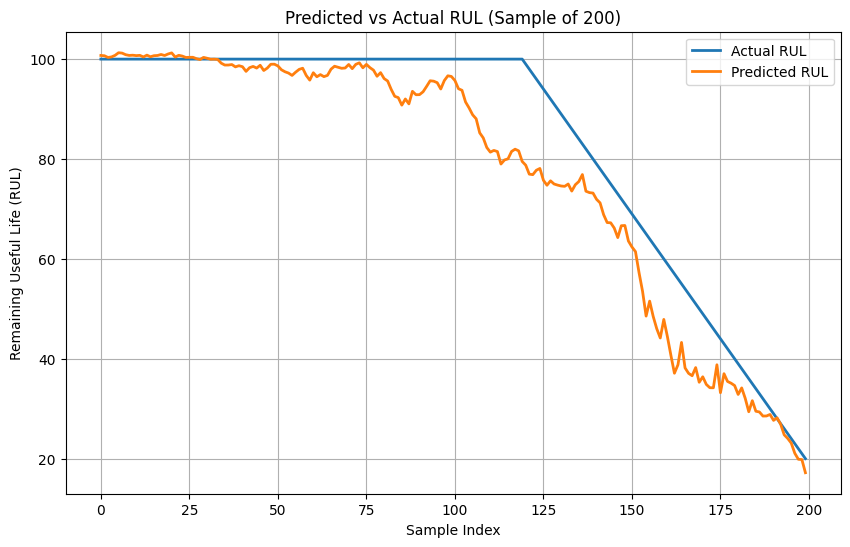

In [11]:
# ✅ 1️⃣ Predictions on Test Set
y_pred = best_model.predict(X_test).flatten()

# ✅ 2️⃣ Plot: Actual vs Predicted RUL
plt.figure(figsize=(10,6))
plt.plot(y_test[:200], label='Actual RUL', linewidth=2)
plt.plot(y_pred[:200], label='Predicted RUL', linewidth=2)
plt.title("Predicted vs Actual RUL (Sample of 200)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()

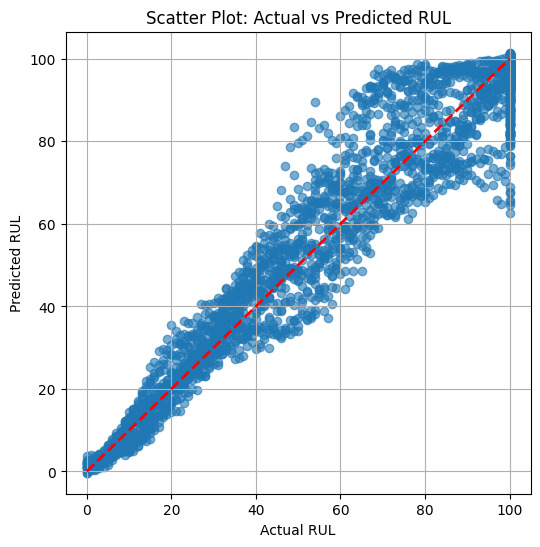

In [12]:
# ✅ 3️⃣ Scatter Plot for Visual Consistency
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("Scatter Plot: Actual vs Predicted RUL")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)
plt.show()

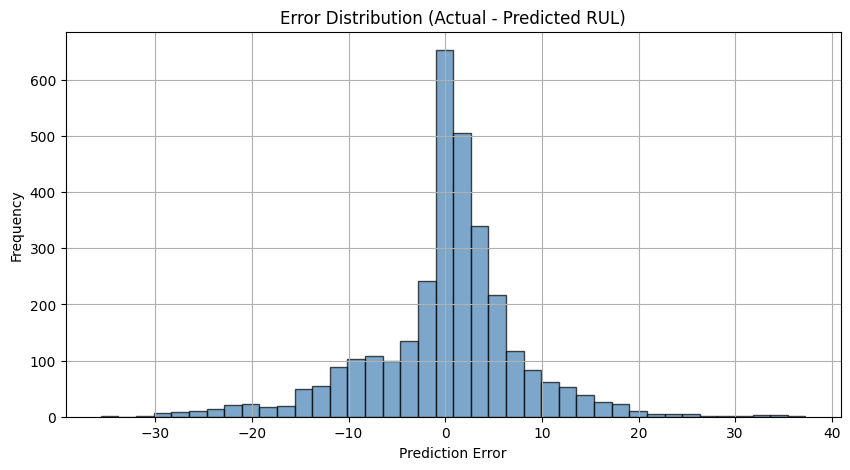

In [13]:
# ✅ 4️⃣ Error Analysis
errors = y_test - y_pred

plt.figure(figsize=(10,5))
plt.hist(errors, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
plt.title("Error Distribution (Actual - Predicted RUL)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [14]:
# ✅ 5️⃣ Bias & Residual Analysis
bias = np.mean(errors)
std_dev = np.std(errors)
abs_error_mean = np.mean(np.abs(errors))
abs_error_max = np.max(np.abs(errors))

print("📈 Model Bias & Residual Analysis:")
print(f"➡️ Mean Bias (Error Mean): {bias:.4f}")
print(f"➡️ Std Dev of Errors: {std_dev:.4f}")
print(f"➡️ Mean Absolute Error (recheck): {abs_error_mean:.4f}")
print(f"➡️ Max Absolute Error: {abs_error_max:.4f}")

📈 Model Bias & Residual Analysis:
➡️ Mean Bias (Error Mean): 0.0178
➡️ Std Dev of Errors: 7.9447
➡️ Mean Absolute Error (recheck): 5.3960
➡️ Max Absolute Error: 37.2771


In [15]:
# ✅ 6️⃣ Evaluation Report Summary
print("\n🧾 --- MODEL EVALUATION REPORT ---")
print(f"Test RMSE  : {rmse:.4f}")
print(f"Test MAE   : {mae:.4f}")
print(f"Test R²    : {R2:.4f}")
print(f"Mean Bias  : {bias:.4f}")
print(f"Error Std  : {std_dev:.4f}")

# ✅ Interpretation Notes
if rmse < 15:
    print("\n✅ Model performance is excellent — RMSE is within acceptable range.")
elif rmse < 30:
    print("\n⚠️ Model is moderately accurate — may need fine-tuning for edge cases.")
else:
    print("\n❌ High RMSE — consider retraining or additional feature engineering.")

print("\n📊 Visual plots confirm prediction trend alignment with actual RUL values.")
print("Residual analysis helps identify over/under-prediction trends across cycles.")


🧾 --- MODEL EVALUATION REPORT ---
Test RMSE  : 7.9447
Test MAE   : 5.3960
Test R²    : 0.9438
Mean Bias  : 0.0178
Error Std  : 7.9447

✅ Model performance is excellent — RMSE is within acceptable range.

📊 Visual plots confirm prediction trend alignment with actual RUL values.
Residual analysis helps identify over/under-prediction trends across cycles.


In [16]:
# Define save path (you can rename it if you want)
MODEL_SAVE_PATH = "final_rul_bilstm_model.h5"

# Save the trained model
model.save(MODEL_SAVE_PATH)

print(f"✅ Model successfully saved at: {MODEL_SAVE_PATH}")

✅ Model successfully saved at: final_rul_bilstm_model.h5


In [17]:
# MILESTONE 4: RISK THRESHOLDING & MAINTENANCE ALERTS
# ============================================================================
print("\n" + "=" * 80)
print("MILESTONE 4: RISK THRESHOLDING & MAINTENANCE ALERTS")
print("=" * 80)



MILESTONE 4: RISK THRESHOLDING & MAINTENANCE ALERTS


In [18]:
# Define alert thresholds
CRITICAL_THRESHOLD = 20  # cycles
WARNING_THRESHOLD = 40   # cycles

print(f"\n--- Alert Thresholds Defined ---")
print(f"⚠ WARNING:  RUL < {WARNING_THRESHOLD} cycles")
print(f"🚨 CRITICAL: RUL < {CRITICAL_THRESHOLD} cycles")



--- Alert Thresholds Defined ---
⚠ WARNING:  RUL < 40 cycles
🚨 CRITICAL: RUL < 20 cycles


In [19]:
def get_alert_level(rul_value):
    """Determine alert level based on predicted RUL"""
    if rul_value < CRITICAL_THRESHOLD:
        return "CRITICAL", "🚨"
    elif rul_value < WARNING_THRESHOLD:
        return "WARNING", "⚠"
    else:
        return "NORMAL", "✓"


In [20]:
# Generate alerts for test samples
print("\n--- Sample Maintenance Alerts (First 20 Test Samples) ---")
for i in range(min(20, len(y_test))):
    pred_rul = y_pred[i]
    actual_rul = y_test[i]
    alert_level, icon = get_alert_level(pred_rul)

    print(f"{icon} Sample {i+1:3d} | Predicted RUL: {pred_rul:6.2f} | "
          f"Actual RUL: {actual_rul:6.2f} | Status: {alert_level:8s}")



--- Sample Maintenance Alerts (First 20 Test Samples) ---
✓ Sample   1 | Predicted RUL: 100.73 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   2 | Predicted RUL: 100.67 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   3 | Predicted RUL: 100.33 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   4 | Predicted RUL: 100.43 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   5 | Predicted RUL: 100.75 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   6 | Predicted RUL: 101.28 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   7 | Predicted RUL: 101.20 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   8 | Predicted RUL: 100.88 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample   9 | Predicted RUL: 100.74 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample  10 | Predicted RUL: 100.78 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample  11 | Predicted RUL: 100.70 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample  12 | Predicted RUL: 100.75 | Actual RUL: 100.00 | Status: NORMAL  
✓ Sample  13 | Pr

In [21]:
# Alert statistics
print("\n--- Alert Statistics Across Test Set ---")
alert_counts = {"NORMAL": 0, "WARNING": 0, "CRITICAL": 0}

for pred_rul in y_pred:
    level, _ = get_alert_level(pred_rul)
    alert_counts[level] += 1

total_alerts = len(y_pred)
print(f"Total test samples: {total_alerts}")
print(f"  ✓ NORMAL:   {alert_counts['NORMAL']:5d} ({alert_counts['NORMAL']/total_alerts*100:.1f}%)")
print(f"  ⚠ WARNING:  {alert_counts['WARNING']:5d} ({alert_counts['WARNING']/total_alerts*100:.1f}%)")
print(f"  🚨 CRITICAL: {alert_counts['CRITICAL']:5d} ({alert_counts['CRITICAL']/total_alerts*100:.1f}%)")



--- Alert Statistics Across Test Set ---
Total test samples: 3156
  ✓ NORMAL:    2376 (75.3%)
  ⚠ WARNING:    391 (12.4%)
  🚨 CRITICAL:   389 (12.3%)



--- Alert Level Distribution ---


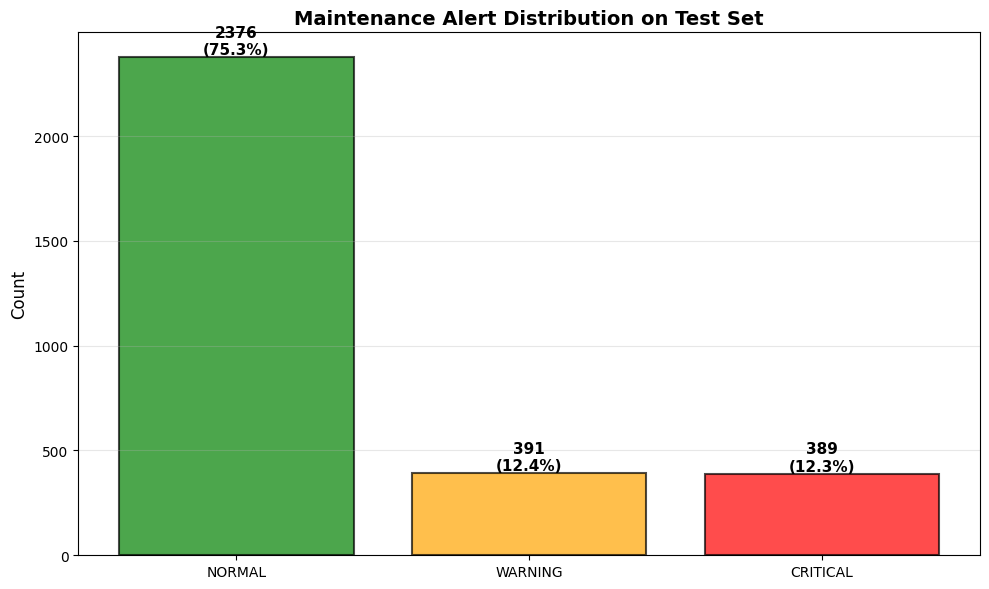

In [22]:
# Visualization: Alert distribution
print("\n--- Alert Level Distribution ---")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = {'NORMAL': 'green', 'WARNING': 'orange', 'CRITICAL': 'red'}
labels = list(alert_counts.keys())
values = list(alert_counts.values())
bar_colors = [colors[label] for label in labels]

bars = ax.bar(labels, values, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Maintenance Alert Distribution on Test Set', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/total_alerts*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



--- RUL Distribution with Alert Thresholds ---


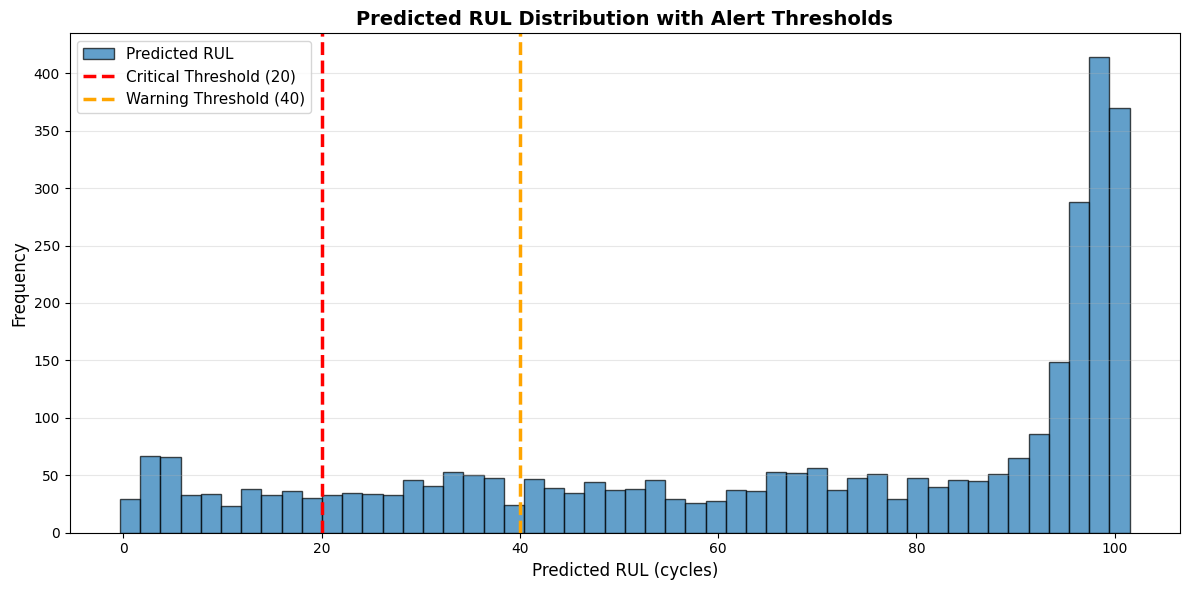

In [23]:
# RUL distribution with thresholds
print("\n--- RUL Distribution with Alert Thresholds ---")
plt.figure(figsize=(12, 6))
plt.hist(y_pred, bins=50, alpha=0.7, edgecolor='black', label='Predicted RUL')
plt.axvline(CRITICAL_THRESHOLD, color='red', linestyle='--', linewidth=2.5,
            label=f'Critical Threshold ({CRITICAL_THRESHOLD})')
plt.axvline(WARNING_THRESHOLD, color='orange', linestyle='--', linewidth=2.5,
            label=f'Warning Threshold ({WARNING_THRESHOLD})')
plt.xlabel('Predicted RUL (cycles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Predicted RUL Distribution with Alert Thresholds', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
